# ADSC Battle of the neighborhoods Final Project
## Topic: Clustering of Safest Neighborhoods in New York
This is the final project for IBM Applied Data Science Capstone Course.<br> 
By: Harsh Vardhan Jaiswal (20th June 2020)

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import requests
import pandas as pd
import numpy as np
!pip install lxml

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

## 1) Dataset Aquisition and Cleaning

### 1.1 Extracting Geo JSON file of New York City for Neighborhood data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Creating a dataframe for Neighborhood data

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


#### Preparing dataframe for Neighborhood data

In [6]:
for data in neighborhoods_data:
    borough = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)    

#### Saving the Neighborhoods dataframe into a CSV

In [7]:
neighborhoods.to_csv("neigh_data1.csv")

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Checking if all the boroughs and neighborhoods are extracted.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Fetching New York City coordinates using GeoPy API

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### 1.2 Extracting the Crime Data for New York city

In [11]:
crime_data = pd.read_csv("https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD")

#### Adding Year and Month columns to the data

In [12]:
crime_data['year'] = pd.DatetimeIndex(crime_data['CMPLNT_FR_DT']).year
crime_data['month'] = pd.DatetimeIndex(crime_data['CMPLNT_FR_DT']).month
crime_data.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,year,month
0,466502077,75,BROOKLYN,03/30/2020,17:30:00,03/31/2020,06:53:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,OPPOSITE OF,PETIT LARCENY,NaN,PATROL BORO BKLYN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/31/2020,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)",2020,3
1,303191835,77,BROOKLYN,03/28/2020,19:30:00,03/28/2020,20:30:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,104,FELONY,OPPOSITE OF,RAPE,NaN,PATROL BORO BKLYN NORTH,157.0,RAPE 1,STREET,03/30/2020,NaN,18-24,UNKNOWN,M,NaN,<18,UNKNOWN,F,1003606,185050,40.674583,-73.930222,"(40.67458330800008, -73.93022154099998)",2020,3
2,735488557,43,BRONX,03/29/2020,14:10:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",DRUG STORE,03/29/2020,NaN,NaN,NaN,NaN,NaN,UNKNOWN,UNKNOWN,D,1019853,241853,40.830443,-73.871349,"(40.83044253800006, -73.871349147)",2020,3
3,315962428,40,BRONX,03/29/2020,07:10:00,03/29/2020,07:16:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",GROCERY/BODEGA,03/29/2020,NaN,UNKNOWN,BLACK,M,NaN,25-44,WHITE HISPANIC,F,1007236,237260,40.817878,-73.916957,"(40.817877907000025, -73.91695668199996)",2020,3
4,165437868,114,QUEENS,03/27/2020,13:15:00,03/27/2020,14:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,344,MISDEMEANOR,INSIDE,ASSAULT 3 & RELATED OFFENSES,NaN,PATROL BORO QUEENS NORTH,101.0,ASSAULT 3,OTHER,03/27/2020,NaN,NaN,NaN,NaN,NaN,45-64,BLACK,F,1002018,213258,40.752011,-73.935872,"(40.75201086000004, -73.93587196099996)",2020,3


#### Dropping all the data that was before 2020
We are only taking data for First Quarter of the year 2020 i.e. Jan 2020 to Mar 2020

In [13]:
crime_data.drop(crime_data[crime_data['year']<2020].index, inplace=True)

In [14]:
crime_data.shape

(102308, 37)

#### Cleaning the crime data by removing the missing data

In [15]:
crime_data_clean = crime_data[crime_data['BORO_NM'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['CMPLNT_TO_DT'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['CMPLNT_TO_TM'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['LOC_OF_OCCUR_DESC'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['OFNS_DESC'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['PATROL_BORO'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['PD_CD'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['PD_DESC'].notna()]
crime_data_clean = crime_data_clean[crime_data_clean['PREM_TYP_DESC'].notna()]

In [16]:
crime_data_clean.shape

(75902, 37)

In [17]:
crime_data_clean['BORO_NM'].value_counts()

BROOKLYN         22753
MANHATTAN        19076
QUEENS           16210
BRONX            14573
STATEN ISLAND     3290
Name: BORO_NM, dtype: int64

#### Renaming the location column of the dataframe
Location column will be used for determining the Neighborhood for each row in the dataset. This will be done using GeoPy API

In [18]:
crime_data_clean.rename(columns={"Lat_Lon":"Locations"}, inplace=True)

In [19]:
crime_data_clean.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Locations,year,month
0,466502077,75,BROOKLYN,03/30/2020,17:30:00,03/31/2020,06:53:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,OPPOSITE OF,PETIT LARCENY,NaN,PATROL BORO BKLYN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/31/2020,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)",2020,3
1,303191835,77,BROOKLYN,03/28/2020,19:30:00,03/28/2020,20:30:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,104,FELONY,OPPOSITE OF,RAPE,NaN,PATROL BORO BKLYN NORTH,157.0,RAPE 1,STREET,03/30/2020,NaN,18-24,UNKNOWN,M,NaN,<18,UNKNOWN,F,1003606,185050,40.674583,-73.930222,"(40.67458330800008, -73.93022154099998)",2020,3
3,315962428,40,BRONX,03/29/2020,07:10:00,03/29/2020,07:16:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",GROCERY/BODEGA,03/29/2020,NaN,UNKNOWN,BLACK,M,NaN,25-44,WHITE HISPANIC,F,1007236,237260,40.817878,-73.916957,"(40.817877907000025, -73.91695668199996)",2020,3
4,165437868,114,QUEENS,03/27/2020,13:15:00,03/27/2020,14:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,344,MISDEMEANOR,INSIDE,ASSAULT 3 & RELATED OFFENSES,NaN,PATROL BORO QUEENS NORTH,101.0,ASSAULT 3,OTHER,03/27/2020,NaN,NaN,NaN,NaN,NaN,45-64,BLACK,F,1002018,213258,40.752011,-73.935872,"(40.75201086000004, -73.93587196099996)",2020,3
14,254029298,40,BRONX,03/22/2020,11:45:00,03/22/2020,15:05:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,INSIDE,ROBBERY,NaN,PATROL BORO BRONX,389.0,"ROBBERY,DWELLING",RESIDENCE - APT. HOUSE,03/22/2020,NaN,25-44,BLACK,M,NaN,18-24,BLACK,F,1004980,236126,40.814771,-73.925111,"(40.81477097700008, -73.92511075099996)",2020,3


#### Extracting the Neighborhoods using the locations (Locations Dataset)
This process takes a lot of time (several hours) as API has slow response time. Hence I have already prepared a dataset with all the locations and the Neighborhoods corresponding to them. For your reference this is the code used 

In [20]:
#for i in range(0,len(locations)):
#    location1 = geolocator.reverse('{}'.format(locations[i][1:-2]))
#    address = location1.raw
#    if 'neighbourhood' in address['address'].keys():
#        neigh = address['address']['neighbourhood']
#        loc_neighbor = loc_neighbor.append({'Location': locations[i],'Neighborhood': neigh}, ignore_index=True)
#        print(locations[i], ",", neigh)
#    else:
#        continue

In [21]:
locations_df = pd.read_csv("https://drive.google.com/uc?id=1N7q6SDuaECyahLeexlHgsE8RYvjwYyaQ&export=download")
locations_df.head()

,Locations,Neighborhoods
0,"(40.65699087900003, -73.87657444799999)",East New York
1,"(40.67458330800008, -73.93022154099998)",Eastern Parkway
2,"(40.817877907000025, -73.91695668199996)",Melrose
3,"(40.75201086000004, -73.93587196099996)",Sunnyside
4,"(40.81477097700008, -73.92511075099996)",Mott Haven


#### Merging the locations data with the Crime data

In [22]:
crime_df = pd.merge(crime_data_clean, locations_df, on='Locations')
crime_df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Locations,year,month,Neighborhoods
0,466502077,75,BROOKLYN,03/30/2020,17:30:00,03/31/2020,06:53:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,OPPOSITE OF,PETIT LARCENY,NaN,PATROL BORO BKLYN NORTH,321.0,"LARCENY,PETIT FROM AUTO",STREET,03/31/2020,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)",2020,3,East New York
1,712779021,75,BROOKLYN,03/19/2020,18:45:00,03/19/2020,19:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,109,FELONY,FRONT OF,GRAND LARCENY,NaN,PATROL BORO BKLYN NORTH,421.0,"LARCENY,GRAND FROM VEHICLE/MOTORCYCLE",STREET,03/19/2020,NaN,UNKNOWN,UNKNOWN,U,NaN,25-44,BLACK,F,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)",2020,3,East New York
2,266802861,75,BROOKLYN,02/20/2020,19:00:00,02/21/2020,07:59:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,109,FELONY,OPPOSITE OF,GRAND LARCENY,NaN,PATROL BORO BKLYN NORTH,421.0,"LARCENY,GRAND FROM VEHICLE/MOTORCYCLE",STREET,02/21/2020,NaN,NaN,NaN,NaN,NaN,25-44,BLACK,M,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)",2020,2,East New York
3,135492571,75,BROOKLYN,02/03/2020,22:15:00,02/03/2020,22:20:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,126,FELONY,INSIDE,MISCELLANEOUS PENAL LAW,NaN,PATROL BORO BKLYN NORTH,198.0,CRIMINAL CONTEMPT 1,RESIDENCE - APT. HOUSE,02/03/2020,NaN,45-64,BLACK,F,NaN,65+,BLACK,F,1018496,178657,40.656991,-73.876574,"(40.65699087900003, -73.87657444799999)",2020,2,East New York
4,303191835,77,BROOKLYN,03/28/2020,19:30:00,03/28/2020,20:30:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,104,FELONY,OPPOSITE OF,RAPE,NaN,PATROL BORO BKLYN NORTH,157.0,RAPE 1,STREET,03/30/2020,NaN,18-24,UNKNOWN,M,NaN,<18,UNKNOWN,F,1003606,185050,40.674583,-73.930222,"(40.67458330800008, -73.93022154099998)",2020,3,Eastern Parkway


In [23]:
crime_df.shape

(50231, 38)

#### Dropping the columns that are not required for the analysis.

In [24]:
crime_clean_df = crime_df.drop(['CMPLNT_NUM','ADDR_PCT_CD','CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM','CRM_ATPT_CPTD_CD','HADEVELOPT','HOUSING_PSA','JURISDICTION_CODE','JURIS_DESC','KY_CD','LOC_OF_OCCUR_DESC','OFNS_DESC','PARKS_NM','PATROL_BORO','PD_CD','PD_DESC','PREM_TYP_DESC','RPT_DT','STATION_NAME','SUSP_AGE_GROUP','SUSP_RACE','SUSP_SEX','TRANSIT_DISTRICT','VIC_AGE_GROUP','VIC_RACE','VIC_SEX','X_COORD_CD','Y_COORD_CD','Latitude','Longitude','Locations','year','month'], axis=1)
crime_clean_df.head()

,BORO_NM,LAW_CAT_CD,Neighborhoods
0,BROOKLYN,MISDEMEANOR,East New York
1,BROOKLYN,FELONY,East New York
2,BROOKLYN,FELONY,East New York
3,BROOKLYN,FELONY,East New York
4,BROOKLYN,FELONY,Eastern Parkway


In [25]:
crime_clean_df.shape

(50231, 3)

#### Preparing pivot table based on type of crimes into variables i.e. FELONY, MISDEMEANOR, VIOLATION

In [26]:
crime_wide_df = pd.get_dummies(crime_clean_df['LAW_CAT_CD'],prefix="", prefix_sep="")
crime_wide_df['Neighborhood'] = crime_clean_df['Neighborhoods']
crime_wide_df['Borough'] = crime_clean_df['BORO_NM']
crime_wide_df.head()
#crime_wide_df.shape

,FELONY,MISDEMEANOR,VIOLATION,Neighborhood,Borough
0,0,1,0,East New York,BROOKLYN
1,1,0,0,East New York,BROOKLYN
2,1,0,0,East New York,BROOKLYN
3,1,0,0,East New York,BROOKLYN
4,1,0,0,Eastern Parkway,BROOKLYN


#### Summing up all the Criminal offences into a single row for a particular neighborhood in a borough.

In [27]:
crime_wide_df = crime_wide_df.groupby(['Neighborhood','Borough']).sum().reset_index()

In [28]:
crime_wide_df.head()

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION
0,Alphabet City,MANHATTAN,25.0,48.0,27.0
1,Annadale,STATEN ISLAND,3.0,12.0,2.0
2,Arlington,STATEN ISLAND,21.0,63.0,20.0
3,Arrochar,STATEN ISLAND,2.0,9.0,2.0
4,Arverne View,QUEENS,37.0,101.0,38.0


### Saving the new dataframe as a csv for further processing

In [29]:
crime_wide_df.to_csv('neigh_data2.csv')

### Getting a combined crime dataset with latitude and longitude values.
This dataset was prepared using the CSV created above from Crime data and the neighborhood dataframe that was created in the beginning for the notebook. 

In [30]:
crime_final_df = pd.read_csv("https://drive.google.com/uc?id=1ASfNnzkoY9_G4reiDyydfg9_NNqHcDYl&export=download")
crime_final_df.head()

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude
0,ANNADALE,STATEN ISLAND,8,20,8,36,40.538114,-74.178549
1,ARLINGTON,STATEN ISLAND,21,63,20,104,40.635325,-74.165104
2,ARROCHAR,STATEN ISLAND,2,9,2,13,40.596313,-74.067124
3,ARVERNE,QUEENS,39,104,38,181,40.589144,-73.791992
4,ASTORIA,QUEENS,55,133,41,229,40.768509,-73.915654


## 2) Methodology

### 2.1 Exploratory data analysis

#### Descriptive statistics on the crime data

In [31]:
crime_final_df.describe()

,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,66.857143,114.844156,35.748918,217.450216,40.704096,-73.952877
std,98.386865,171.142813,52.060226,315.964536,0.097375,0.121677
min,0.000000,1.000000,0.000000,1.000000,40.505334,-74.246569
25%,8.000000,16.500000,6.500000,33.500000,40.622638,-74.010491
50%,33.000000,67.000000,20.000000,130.000000,40.705179,-73.944182
75%,85.500000,155.500000,44.000000,286.500000,40.769667,-73.863736
max,901.000000,1855.000000,557.000000,3313.000000,40.898273,-73.715481


#### Fetching 10 most unsafe neighborhoods in New York city

In [32]:
unsafe_neigh_df = crime_final_df.nlargest(10, 'Total').reset_index()
unsafe_neigh_df = unsafe_neigh_df.drop(['index'], axis=1)
unsafe_neigh_df

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude
0,EAST HARLEM,MANHATTAN,901,1855,557,3313,40.792249,-73.944182
1,MIDTOWN,MANHATTAN,641,951,188,1780,40.754691,-73.981669
2,BEDFORD STUYVESANT,BROOKLYN,308,589,212,1109,40.687232,-73.941785
3,LOWER EAST SIDE,MANHATTAN,303,558,178,1039,40.717807,-73.980890
4,CROWN HEIGHTS,BROOKLYN,324,479,178,981,40.670829,-73.943291
5,FLATBUSH,BROOKLYN,332,453,156,941,40.636326,-73.958401
6,EAST NEW YORK,BROOKLYN,409,354,161,924,40.669926,-73.880699
7,MELROSE,BRONX,234,449,155,838,40.819754,-73.909422
8,MOTT HAVEN,BRONX,185,462,125,772,40.806239,-73.916100
9,EAST VILLAGE,MANHATTAN,201,432,113,746,40.727847,-73.982226


#### Visualizing data using barchart for the unsafe neighborhoods 

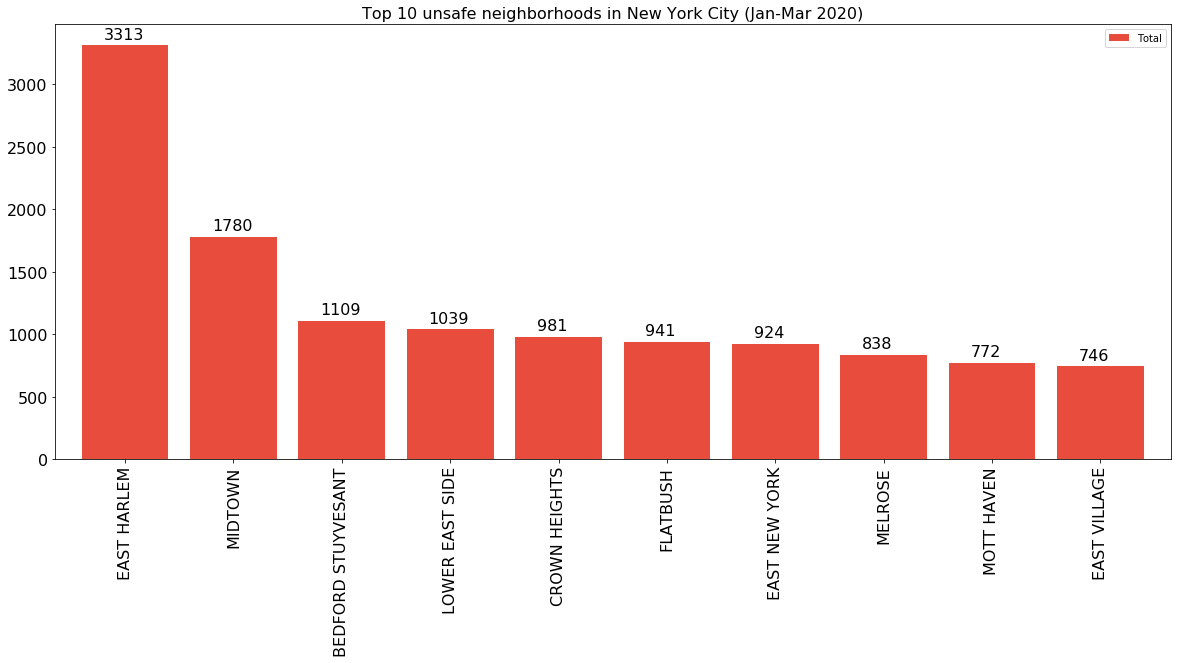

In [33]:
unsafe = unsafe_neigh_df[['Neighborhood', 'Total']]
unsafe.plot(kind='bar', figsize=(20,8), width=0.8, color=['#e74c3c'], fontsize=16)
plt.title("Top 10 unsafe neighborhoods in New York City (Jan-Mar 2020)", fontsize=16)
ax = plt.gca()
style = dict(size=16, color='black')
for index in range(0, unsafe['Neighborhood'].count()):
    ax.text(index-0.2, unsafe['Total'][index]+50, unsafe['Total'][index], **style)
ax = plt.xticks(np.arange(10), unsafe['Neighborhood'])


#### Fetching 20 safest neighborhoods in the City

In [34]:
safe_neighborhood = crime_final_df.nsmallest(20, 'Total').reset_index()
safe_neighborhood = safe_neighborhood.drop(['index'], axis=1)
safe_neighborhood

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude
0,EDGEWATER PARK,BRONX,0,1,0,1,40.821986,-73.813885
1,SOUTH SIDE,BROOKLYN,0,1,0,1,40.710861,-73.958001
2,CHARLESTON,STATEN ISLAND,2,1,0,3,40.530531,-74.232158
3,CHELSEA,STATEN ISLAND,0,1,3,4,40.594726,-74.189560
4,HUGUENOT,STATEN ISLAND,0,3,1,4,40.531912,-74.191741
5,PRINCES BAY,STATEN ISLAND,2,3,1,6,40.526264,-74.201526
6,BROAD CHANNEL,QUEENS,4,3,0,7,40.603027,-73.820055
7,ROSSVILLE,STATEN ISLAND,1,3,3,7,40.549404,-74.215729
8,BLOOMFIELD,STATEN ISLAND,0,4,4,8,40.605779,-74.187256
9,DOUGLASTON,QUEENS,3,4,1,8,40.766846,-73.742498


#### Visualizing data using barchart for the safest neighborhoods in the city

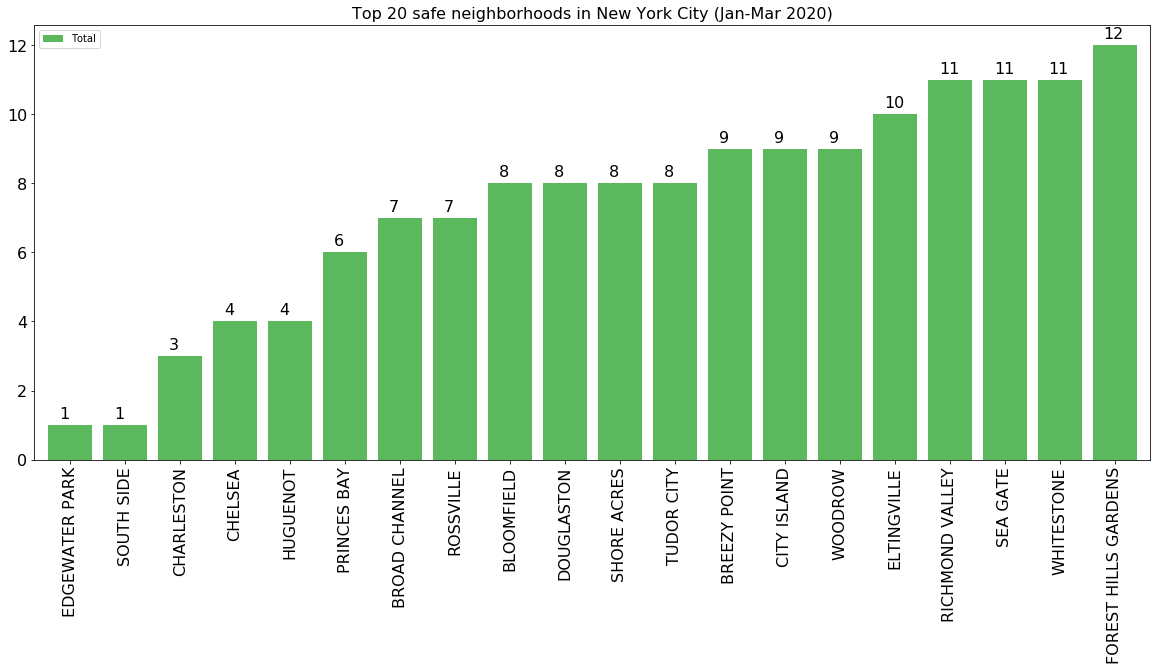

In [35]:
safe = safe_neighborhood[['Neighborhood', 'Total']]
safe.plot(kind='bar', figsize=(20,8), width=0.8, color=['#5cb85c'], fontsize=16)
plt.title("Top 20 safe neighborhoods in New York City (Jan-Mar 2020)", fontsize=16)
ax = plt.gca()
style = dict(size=16, color='black')
for index in range(0, safe['Neighborhood'].count()):
    ax.text(index-0.2, safe['Total'][index]+0.2, safe['Total'][index], **style)
ax = plt.xticks(np.arange(20), safe['Neighborhood'])


#### Foursqaure API credentials

In [36]:
CLIENT_ID = 'L2ZA4VM3HEZUL01MGEI3QOEO2I1EVBHFKWJIGLF524A4GEA2' # your Foursquare ID
CLIENT_SECRET = '1UIGS12PFFQMLJRLXQPEYHWFJLHYSNRHEHUMRS2K5UKHUQGD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: L2ZA4VM3HEZUL01MGEI3QOEO2I1EVBHFKWJIGLF524A4GEA2
CLIENT_SECRET:1UIGS12PFFQMLJRLXQPEYHWFJLHYSNRHEHUMRS2K5UKHUQGD


#### Exploring the first Neighborhood

In [37]:
safe_neighborhood.loc[0,'Neighborhood']

'EDGEWATER PARK'

In [38]:
neighborhood_latitude = safe_neighborhood.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = safe_neighborhood.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = safe_neighborhood.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of EDGEWATER PARK are 40.82198612, -73.81388514.


#### Creating GET request link for Foursquare API

In [39]:
radius=500
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighborhood_latitude,
    neighborhood_longitude,
    radius,
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=L2ZA4VM3HEZUL01MGEI3QOEO2I1EVBHFKWJIGLF524A4GEA2&client_secret=1UIGS12PFFQMLJRLXQPEYHWFJLHYSNRHEHUMRS2K5UKHUQGD&v=20180605&ll=40.82198612,-73.81388514&radius=500&limit=100'

#### Extracting the data for venues in JSON

In [40]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eee55b2882fc7001bac62c7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Throgs Neck',
  'headerFullLocation': 'Throgs Neck, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 20,
  'suggestedBounds': {'ne': {'lat': 40.8264861245, 'lng': -73.80794971016196},
   'sw': {'lat': 40.817486115499996, 'lng': -73.81982056983803}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bf471c198ac0f47190664a8',
       'name': 'Muscle Maker Grill',
       'location': {'address': '4041 E Tremont Ave',
        'crossStreet': 'at Miles Ave',
        'lat': 40.81939123374593,
        'lng': -73.81729767562672,
        'labeledLatLngs': [{'l

#### Function to get the category type for the Venues

In [41]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Creating the dataframe for the venues of the first Neighborhood

In [42]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Muscle Maker Grill,American Restaurant,40.819391,-73.817298
1,Tommy's Pizzeria,Pizza Place,40.819573,-73.817482
2,The Miles Coffee Bar,Coffee Shop,40.819462,-73.817352
3,Tosca Café,Bar,40.819204,-73.817467
4,The Wicked Wolf,Pub,40.819688,-73.817359


#### Showing the no.of venues that were nearby the first Neighborhood.

In [43]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

20 venues were returned by Foursquare.


#### Function to fetch nearby venues for all the Neighborhoods in the dataset using FourSquare API.

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [45]:
safe_neighborhood_venues = getNearbyVenues(names=safe_neighborhood['Neighborhood'],
                                   latitudes=safe_neighborhood['Latitude'],
                                   longitudes=safe_neighborhood['Longitude']
                                  )

EDGEWATER PARK
SOUTH SIDE
CHARLESTON
CHELSEA
HUGUENOT
PRINCES BAY
BROAD CHANNEL
ROSSVILLE
BLOOMFIELD
DOUGLASTON
SHORE ACRES
TUDOR CITY
BREEZY POINT
CITY ISLAND
WOODROW
ELTINGVILLE
RICHMOND VALLEY
SEA GATE
WHITESTONE
FOREST HILLS GARDENS


#### Getting the shape of the venues dataset and displaying it's first 5 rows

In [46]:
print(safe_neighborhood_venues.shape)
safe_neighborhood_venues.head()

(451, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EDGEWATER PARK,40.821986,-73.813885,Muscle Maker Grill,40.819391,-73.817298,American Restaurant
1,EDGEWATER PARK,40.821986,-73.813885,Tommy's Pizzeria,40.819573,-73.817482,Pizza Place
2,EDGEWATER PARK,40.821986,-73.813885,The Miles Coffee Bar,40.819462,-73.817352,Coffee Shop
3,EDGEWATER PARK,40.821986,-73.813885,Tosca Café,40.819204,-73.817467,Bar
4,EDGEWATER PARK,40.821986,-73.813885,The Wicked Wolf,40.819688,-73.817359,Pub


#### Getting no. of venues returned for each Neighborhood

In [47]:
#safe_neighborhood_venues.groupby('Neighborhood').count()
safe_neighborhood_venues['Neighborhood'].value_counts()

SOUTH SIDE              100
TUDOR CITY               74
ELTINGVILLE              37
CITY ISLAND              30
CHARLESTON               28
SHORE ACRES              25
FOREST HILLS GARDENS     23
DOUGLASTON               21
WOODROW                  20
EDGEWATER PARK           20
ROSSVILLE                16
RICHMOND VALLEY          12
HUGUENOT                  9
PRINCES BAY               9
BROAD CHANNEL             6
SEA GATE                  5
CHELSEA                   4
BREEZY POINT              4
BLOOMFIELD                4
WHITESTONE                4
Name: Neighborhood, dtype: int64

#### No. of unique categories of venues

In [48]:
print('There are {} uniques categories.'.format(len(safe_neighborhood_venues['Venue Category'].unique())))

There are 144 uniques categories.


## Analyzing each neighborhood

#### Doing hot encoding based on venue category for Venues in safe neighborhoods dataset

In [49]:
# one hot encoding
safe_neigh_venues_onehot = pd.get_dummies(safe_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
safe_neigh_venues_onehot['Neighborhood'] = safe_neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [safe_neigh_venues_onehot.columns[-1]] + list(safe_neigh_venues_onehot.columns[:-1])
safe_neigh_venues_onehot = safe_neigh_venues_onehot[fixed_columns]

safe_neigh_venues_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Garden,Big Box Store,Bike Shop,Boat or Ferry,Bookstore,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Event Space,Fast Food Restaurant,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Heliport,History Museum,Home Service,Hotel,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Nightlife,Park,Pet Store,Pharmacy,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pub,Recreation Center,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Smoke Shop,Smoothie Shop,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,EDGEWATER PARK,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,EDGEWATER PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,EDGEWATER PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,EDGEWATER PARK,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,EDGEWATER PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Examining the data size

In [50]:
safe_neigh_venues_onehot.shape

(451, 145)

#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each venue category

In [51]:
safe_neigh_grouped = safe_neigh_venues_onehot.groupby(['Neighborhood']).mean().reset_index()
safe_neigh_grouped

,Neighborhood,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Garden,Big Box Store,Bike Shop,Boat or Ferry,Bookstore,Boxing Gym,Breakfast Spot,Bridge,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Event Space,Fast Food Restaurant,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Heliport,History Museum,Home Service,Hotel,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moving Target,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Nightlife,Park,Pet Store,Pharmacy,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pub,Recreation Center,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Smoke Shop,Smoothie Shop,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Thai Restaurant,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,BLOOMFIELD,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.25,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000
1,BREEZY POINT,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.25,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000

In [52]:
safe_neigh_grouped.shape

(20, 145)

#### Let's print each neighborhood along with the top 5 most common venues

In [53]:
num_top_venues = 5

for hood in safe_neigh_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = safe_neigh_grouped[safe_neigh_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BLOOMFIELD----
               venue  freq
0  Recreation Center  0.25
1       Burger Joint  0.25
2           Bus Stop  0.25
3         Theme Park  0.25
4         Nail Salon  0.00


----BREEZY POINT----
                 venue  freq
0                Beach  0.50
1  Monument / Landmark  0.25
2                Trail  0.25
3  American Restaurant  0.00
4                 Park  0.00


----BROAD CHANNEL----
                 venue  freq
0        Deli / Bodega  0.17
1  Sporting Goods Shop  0.17
2             Dive Bar  0.17
3          Bus Station  0.17
4          Pizza Place  0.17


----CHARLESTON----
                 venue  freq
0          Coffee Shop  0.07
1       Cosmetics Shop  0.07
2        Big Box Store  0.07
3  American Restaurant  0.04
4         Burger Joint  0.04


----CHELSEA----
                venue  freq
0                Park  0.25
1  Spanish Restaurant  0.25
2      Sandwich Place  0.25
3          Steakhouse  0.25
4     Other Nightlife  0.00


----CITY ISLAND----
                    v

#### This function retuns the N no. of most common venues of a Neighborhood

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = safe_neigh_grouped['Neighborhood']

for ind in np.arange(safe_neigh_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(safe_neigh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BLOOMFIELD,Theme Park,Recreation Center,Burger Joint,Bus Stop,Yoga Studio,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Event Space
1,BREEZY POINT,Beach,Trail,Monument / Landmark,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop,Food
2,BROAD CHANNEL,Deli / Bodega,Pizza Place,Sporting Goods Shop,Dive Bar,Other Nightlife,Bus Station,Event Space,Food & Drink Shop,Food,Fast Food Restaurant
3,CHARLESTON,Big Box Store,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Furniture / Home Store,Pet Store,Music Venue,Kids Store,Hardware Store,Gym / Fitness Center
4,CHELSEA,Steakhouse,Spanish Restaurant,Park,Sandwich Place,Dry Cleaner,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Event Space


#### K-means clustering of the safest neighborhoods

In [56]:
kclusters = 3

safe_neigh_grouped_clustering = safe_neigh_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(safe_neigh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

safe_neigh_merged = safe_neighborhood

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
safe_neigh_merged = safe_neigh_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

safe_neigh_merged.head() # check the last columns!

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,EDGEWATER PARK,BRONX,0,1,0,1,40.821986,-73.813885,1,Italian Restaurant,Pizza Place,Donut Shop,American Restaurant,Liquor Store,Park,Pub,Coffee Shop,Chinese Restaurant,Sports Bar
1,SOUTH SIDE,BROOKLYN,0,1,0,1,40.710861,-73.958001,1,Bar,Coffee Shop,American Restaurant,Pizza Place,Wine Bar,Breakfast Spot,Yoga Studio,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant
2,CHARLESTON,STATEN ISLAND,2,1,0,3,40.530531,-74.232158,1,Big Box Store,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Furniture / Home Store,Pet Store,Music Venue,Kids Store,Hardware Store,Gym / Fitness Center
3,CHELSEA,STATEN ISLAND,0,1,3,4,40.594726,-74.189560,1,Steakhouse,Spanish Restaurant,Park,Sandwich Place,Dry Cleaner,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Event Space
4,HUGUENOT,STATEN ISLAND,0,3,1,4,40.531912,-74.191741,1,Italian Restaurant,Asian Restaurant,Donut Shop,Sandwich Place,Moving Target,Bank,Deli / Bodega,Train Station,Ice Cream Shop,Heliport


### Visualizing the neighborhoods after clustering on the map.
#### All the clusters are color coded
1) Cluster 1 = Red <br>
2) Cluster 2 = Purple <br>
3) Cluster 3 = Sea Green <br>

In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(safe_neigh_merged['Latitude'], safe_neigh_merged['Longitude'], safe_neigh_merged['Neighborhood'], safe_neigh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1 (Red)

In [59]:
safe_neigh_merged.loc[safe_neigh_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,BLOOMFIELD,STATEN ISLAND,0,4,4,8,40.605779,-74.187256,0,Theme Park,Recreation Center,Burger Joint,Bus Stop,Yoga Studio,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Event Space


#### Cluster 2 (Purple)

In [60]:
safe_neigh_merged.loc[safe_neigh_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,EDGEWATER PARK,BRONX,0,1,0,1,40.821986,-73.813885,1,Italian Restaurant,Pizza Place,Donut Shop,American Restaurant,Liquor Store,Park,Pub,Coffee Shop,Chinese Restaurant,Sports Bar
1,SOUTH SIDE,BROOKLYN,0,1,0,1,40.710861,-73.958001,1,Bar,Coffee Shop,American Restaurant,Pizza Place,Wine Bar,Breakfast Spot,Yoga Studio,Japanese Restaurant,Sushi Restaurant,Chinese Restaurant
2,CHARLESTON,STATEN ISLAND,2,1,0,3,40.530531,-74.232158,1,Big Box Store,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Furniture / Home Store,Pet Store,Music Venue,Kids Store,Hardware Store,Gym / Fitness Center
3,CHELSEA,STATEN ISLAND,0,1,3,4,40.594726,-74.189560,1,Steakhouse,Spanish Restaurant,Park,Sandwich Place,Dry Cleaner,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Event Space
4,HUGUENOT,STATEN ISLAND,0,3,1,4,40.531912,-74.191741,1,Italian Restaurant,Asian Restaurant,Donut Shop,Sandwich Place,Moving Target,Bank,Deli / Bodega,Train Station,Ice Cream Shop,Heliport
5,PRINCES BAY,STATEN ISLAND,2,3,1,6,40.526264,-74.201526,1,Pizza Place,Bank,Pharmacy,Pet Store,Construction & Landscaping,Bagel Shop,Sushi Restaurant,Chinese Restaurant,Dry Cleaner,Food & Drink Shop
6,BROAD CHANNEL,QUEENS,4,3,0,7,40.603027,-73.820055,1,Deli / Bodega,Pizza Place,Sporting Goods Shop,Dive Bar,Other Nightlife,Bus Station,Event Space,Food & Drink Shop,Food,Fast Food Restaurant
7,ROSSVILLE,STATEN ISLAND,1,3,3,7,40.549404,-74.215729,1,Pizza Place,Bagel Shop,American Restaurant,Chinese Restaurant,Liquor Store,Grocery Store,Moving Target,Dry Cleaner,Donut Shop,Deli / Bodega
9,DOUGLASTON,QUEENS,3,4,1,8,40.766846,-73.742498,1,Deli / Bodega,Chinese Restaurant,Bank,Ice Cream Shop,Lounge,Diner,Convenience Store,Donut Shop,Fast Food Restaurant,Shanghai Restaurant
10,SHORE ACRES,STATEN ISLAND,0,5,3,8,40.609719,-74.066678,1,Italian Restaurant,Bus Stop,Intersection,Deli / Bodega,Bar,Supermarket,Gastropub,Furniture / Home Store,Music Store,Food


#### Cluster 3 (Sea Green)

In [61]:
safe_neigh_merged.loc[safe_neigh_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,FELONY,MISDEMEANOR,VIOLATION,Total,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,BREEZY POINT,QUEENS,1,6,2,9,40.557401,-73.925512,2,Beach,Trail,Monument / Landmark,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food & Drink Shop,Food
17,SEA GATE,BROOKLYN,4,5,2,11,40.576375,-74.007873,2,American Restaurant,Beach,Bus Station,Spa,Sports Club,History Museum,French Restaurant,Department Store,Dessert Shop,Diner
